In [4]:
### segmentation https://github.com/getsanjeev/retina-features/blob/master/bloodvessels.py

import cv2
import numpy as np
import os
import csv

def CLAHE(img):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(img)

def extract_green(img):
  b,g,r = cv2.split(img)
  return g

def extract_bv(img_g):		
    
  clahe_g = CLAHE(img_g)
    
	# applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(clahe_g, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
  f4 = cv2.subtract(R3,clahe_g)
  f5 = CLAHE(f4)	

	# removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
  contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
	#vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)	
  xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
  xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   				
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      hape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
  blood_vessels = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	#blood_vessels = cv2.bitwise_not(finimage)
  return blood_vessels	

def remove_edge(ori_img, vessel_img, e = 20, r = 9, i = 5):

  ret, fundus_edge_mask = cv2.threshold(ori_img, 30, 255, cv2.THRESH_BINARY)
  #plt.imshow(fundus_edge_mask,cmap="gray")
  #plt.show()
  x, y = ori_img.shape
  remain = []
  i = 0
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * r + 1, 2 * r + 1))
  if x < y:
    num_pixels = np.sum(fundus_edge_mask,axis = 0)
    for col in num_pixels:
      if col != 0:
        remain.append(i)
      i += 1
    vessel_img = vessel_img[:,remain]
    mask_erode = cv2.erode(fundus_edge_mask, kernel, iterations=10)/255
    mask_erode = mask_erode[:,remain]
    mask_erode[:e,:] = 0
    mask_erode[-e:,:] = 0
  else:
    num_pixels = np.sum(fundus_edge_mask,axis = 1)
    for row in num_pixels:
      if row != 0:
        remain.append(i)
      i += 1
    vessel_img = vessel_img[remain,:]
    mask_erode = cv2.erode(fundus_edge_mask, kernel, iterations=10)/255
    mask_erode = mask_erode[remain,:]
    mask_erode[:,:e] = 0
    mask_erode[:,-e:] = 0
  
  #plt.imshow(mask_erode,cmap="gray")
  #plt.show()

  vessel_img_masked = mask_erode * vessel_img
  #plt.imshow(vessel_img_masked, cmap = "gray")
    
  return vessel_img_masked

def gaussian_blur(img, d, i):
  img_GaussianBlur=cv2.GaussianBlur(img,(d,d),i)
    
  return img_GaussianBlur

def median_blur(img, d, i):
  img_MedianBlur=cv2.MedianBlur(img,d,i)
    
  return img_MedianBlur


pathFolder = "/content/drive/MyDrive/glaucoma/vessel_input"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
destinationFolder = "/content/drive/MyDrive/glaucoma/vessel_segmentation/"
for file_name in filesArray:
  file_name_no_extension = os.path.splitext(file_name)[0]
  fundus = cv2.imread(pathFolder+'/'+file_name)
  fundus_g = extract_green(fundus)
  bloodvessel = extract_bv(fundus_g)
  bloodvessel_no_edge = remove_edge(fundus_g, bloodvessel)
  bloodvessel_blur = gaussian_blur(bloodvessel_no_edge, 25, 5)
  cv2.imwrite(destinationFolder+file_name_no_extension+"_bloodvessel.png",bloodvessel_blur)        

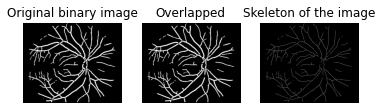

In [6]:
### skeleton https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm/blob/master/thinning.py

import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu
from skimage.transform import resize

def skeletonization_preprocessing(path):
  "load image data"
  Img_Original =  cv2.imread(path, 0)      # Gray image, rgb images need pre-conversion

  "Convert gray images to binary images using Otsu's method"
  Otsu_Threshold = threshold_otsu(Img_Original)   
  BW_Original = Img_Original > Otsu_Threshold    # must set object region as 1, background region as 0 !
  img_length = 512
  x, y = BW_Original.shape
  if x < y:
    y = int(y*img_length/x)
    BW_Original = resize(BW_Original, (img_length,y))
  else:
    x = int(x*img_length/y)
    BW_Original = resize(BW_Original, (x,img_length))
  
  return BW_Original

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned
 
def overlap(bw_img, BW_Skeleton):
  Image_Thinned_Denoise = cv2.bitwise_or(bw_img,BW_Skeleton)
  return Image_Thinned_Denoise


path = "/content/drive/MyDrive/glaucoma/vessel_segmentation/001_bloodvessel.png"
"Apply the algorithm on images"
BW_Original = skeletonization_preprocessing(path)
BW_Skeleton = zhangSuen(BW_Original)
BW_Skeleton_overlap = overlap(BW_Original, BW_Skeleton)
# BW_Skeleton = BW_Original
"Display the results"
fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.ravel()
ax1.imshow(BW_Original, cmap=plt.cm.gray)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton_overlap, cmap=plt.cm.gray)
ax2.set_title('Overlapped')
ax2.axis('off')
ax3.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax3.set_title('Skeleton of the image')
ax3.axis('off')
plt.show()

plt.imsave("/content/drive/MyDrive/glaucoma/vessel_skeleton/001_bloodvessel_skeleton.png", BW_Skeleton, cmap="gray")
plt.imsave("/content/drive/MyDrive/glaucoma/vessel_skeleton/overlap_001_bloodvessel_skeleton.png", BW_Skeleton_overlap, cmap="gray")

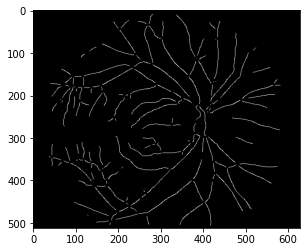

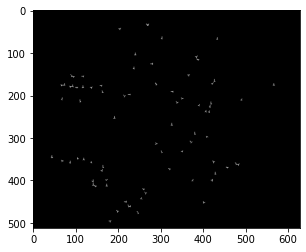

In [7]:
### bifurcation detection

import numpy as np

def find_neighbours(img, i, j, r):
    return img[i-r:i+r+1,j-r:j+r+1]
'''
def is_neighbour(point1, point2, d=1):
    neighbour = False
    if abs(point1[0]-point2[0]) <= d:
        if abs(point1[0]-point2[0]) <= d:
            neighbour = True
    return neighbour
'''
def find_bifurcation(img, r=3):

  vessel_points = np.argwhere(img == 1)
  
  mask_circle = np.zeros((2*r+1,2*r+1))
  cv2.circle(mask_circle, (r,r), r, 1, 1)
  circle_points = np.argwhere(mask_circle == 1)
  mask_round = np.ones((2*r+1,2*r+1))
  cv2.circle(mask_round, (r,r), r, 0, -1)

  for x, y in vessel_points:
    neighbours = find_neighbours(img, x, y, r)
    crossed = cv2.bitwise_and(neighbours, mask_circle)
    if cv2.countNonZero(crossed) >= 3:
      for i, j in circle_points:
        neighbouring_points = find_neighbours(crossed, i, j, 1)
        if cv2.countNonZero(neighbouring_points) > 1:
          crossed[i,j] = 0
      if cv2.countNonZero(crossed) >= 3:
        img[x-r:x+r+1,y-r:y+r+1] = cv2.bitwise_and(neighbours, mask_round)
  return img

img = find_bifurcation(BW_Skeleton.copy())

plt.imshow(img, cmap="gray")
plt.show()
img_bifurcation = BW_Skeleton - img
plt.imshow(img_bifurcation, cmap="gray")
plt.show()

plt.imsave("/content/drive/MyDrive/glaucoma/vessel_bifurcation/001_bloodvessel_no_crossing.png", img, cmap="gray")
plt.imsave("/content/drive/MyDrive/glaucoma/vessel_bifurcation/overlap_001_bloodvessel_bifurcation.png", img_bifurcation, cmap="gray")

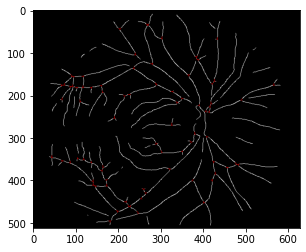

In [8]:
img_rgb = np.zeros((img.shape[0],img.shape[1],3))
img_rgb[:,:,0] = BW_Skeleton
img_rgb[:,:,1] = img
img_rgb[:,:,2] = img
plt.imshow(img_rgb)
plt.imsave("/content/drive/MyDrive/glaucoma/vessel_bifurcation/001_bloodvessel_bifurcation_rgb.png",img_rgb)

In [9]:
import random
def random_color(i):
  random.seed(i)
  r = random.randint(100,255)
  random.seed(i*i)
  g = random.randint(100,255)
  random.seed(i*i*i)
  b = random.randint(100,255)

  return [r,g,b]

In [10]:
def traverse_points(g, x, y, img, groups, points, neighbour_mask, img_group, color):
  neighbour_points = find_neighbours(img, x, y, 1)
  neighbour_points = cv2.bitwise_and(neighbour_points, neighbour_mask)
  neighbour_points = np.argwhere(neighbour_points == 1)
  if img[x,y] != 0:
    img[x,y] = 0
    groups[x,y] = g
    img_group[x,y,:] = color
    #print((x,y))
    points.remove((x,y))
    for i,j in neighbour_points:
      traverse_points(g, x+i-1, j+y-1, img, groups, points, neighbour_mask, img_group, color)

def group_bifurcation(img):
  points = np.argwhere(img == 1)
  points = list(map(lambda x: tuple(x),[point for point in points]))
  #print(points)
  groups = np.zeros(img.shape)
  img_group = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  #print(points.shape)
  g = 0

  neighbour_mask = np.ones((3,3))
  neighbour_mask[1,1] = 0

  dists = []

  for x, y in points:
    g += 1
    d = 0
    color = random_color(g)
    traverse_points(g, x, y, img, groups, points, neighbour_mask, img_group, color)
  
  plt.imsave("/content/drive/MyDrive/glaucoma/vessel_bifurcation/001_bloodvessel_bifurcation_groups.png",img_group)

  return g

print("Number of bifurcations and crossings:",group_bifurcation(img_bifurcation.copy()))

Number of bifurcations and crossings: 65


In [11]:
import numpy as np
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
from skimage.exposure import rescale_intensity
import random
import math

def traverse_vessels(g, x, y, img, groups, points, neighbour_mask, img_group, color, d):
  neighbour_points = find_neighbours(img, x, y, 1)
  neighbour_points = cv2.bitwise_and(neighbour_points, neighbour_mask)
  neighbour_points = np.argwhere(neighbour_points == 1)
  if img[x,y] != 0:
    img[x,y] = 0
    groups[x,y] = g
    img_group[x,y,:] = color
    #print((x,y))
    points.remove((x,y))
    for i,j in neighbour_points:
      d[0] += math.sqrt(abs(1-i) + abs(1-j))
      #print(d)
      traverse_vessels(g, x+i-1, j+y-1, img, groups, points, neighbour_mask, img_group, color, d)
  return d
  
def count_vessel_length(img):
  points = np.argwhere(img == 1)
  points = list(map(lambda x: tuple(x),[point for point in points]))
  #print(points)
  groups = np.zeros(img.shape)
  img_group = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  #print(points.shape)
  g = 0
  dist = []
  neighbour_mask = np.ones((3,3))
  neighbour_mask[1,1] = 0

  for x, y in points:
    g += 1
    color = random_color(g)
    d = [0]
    d = traverse_vessels(g, x, y, img, groups, points, neighbour_mask, img_group, color, d)
    dist.append(d[0])

  plt.imsave("/content/drive/MyDrive/glaucoma/vessel_bifurcation/001_bloodvessel_groups.png",img_group)
  
  return g, dist
g, dist = count_vessel_length(img.copy())
print("Vessel length:", sum(dist))
print("Number of vessels:", g)
print("Number of pixels:", cv2.countNonZero(img))

Vessel length: 9311.772721475254
Number of vessels: 141
Number of pixels: 6640
